In [1]:
from Calculators.GED_Calculator import build_GED_calculator, build_Heuristic_calculator, build_Randomwalk_GED_calculator
# from Calculators.Product_GRaphs import RandomWalkCalculator
from Dataset import Dataset
from Experiment import experiment
import sys
import os
import traceback

from Models.SVC.GED.hybrid_prototype_selector import HybridPrototype_GED_SVC
# add the current directory to the system path
sys.path.append(os.getcwd())
from Models.SVC.GED.RandomWalk_edit import Random_Walk_edit_accelerated, Random_walk_edit_SVC
from Models.SVC.WeisfeilerLehman_SVC import WeisfeilerLehman_SVC
from Models.Graph_Classifier import GraphClassifier
from Models.SVC.Baseline_SVC import VertexHistogram_SVC,EdgeHistogram_SVC, CombinedHistogram_SVC, NX_Histogram_SVC
from Models.Blind_Classifier import Blind_Classifier
from Models.Random_Classifer import Random_Classifier
from Models.KNN_Classifer import KNN
from Models.SVC.GED.Trivial_GED_SVC import Trivial_GED_SVC
from Custom_Kernels.GEDLIB_kernel import GEDKernel
from Calculators.Dummy_Calculator import Dummy_Calculator
from Calculators.Base_Calculator import Base_Calculator
from Calculators.GEDLIB_Caclulator import GEDLIB_Calculator
from Models.SVC.GED.GED_Diffu_SVC import DIFFUSION_GED_SVC
from Models.SVC.GED.Zero_GED_SVC import ZERO_GED_SVC
from Models.SVC.GED.simiple_prototype_GED_SVC import Simple_Prototype_GED_SVC
from Models.SVC.Base_GED_SVC import Base_GED_SVC, set_global_ged_calculator
from Models.KNN.GEDLIB_KNN import GED_KNN, set_global_ged_calculator_KNN
from Models.KNN.feature_KNN import Feature_KNN
import pandas as pd
from io_Manager import IO_Manager


In [2]:
DATASET_NAME="MUTAG"
PRELOAD_CALCULATORS=True
USE_NODE_LABELS="labels"
USE_EDGE_LABELS="labels"
GED_BOUND="IPFP"  # "UpperBound-Distance", "Mean-Distance", "LowerBound-Distance"
def get_classifier(ged_calculator):
    set_global_ged_calculator_KNN(ged_calculator)

    # return ZERO_GED_SVC(calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, C=1.0,kernel_type="precomputed", selection_split="classwise",prototype_size=7, aggregation_method="sum",dataset_name=DATASET.name,selection_method="k-CPS")
    # return Random_walk_edit_SVC(ged_calculator=ged_calculator, ged_bound=GED_BOUND, decay_lambda=0.1, max_walk_length=-1, C=1.0,kernel_type="precomputed", class_weight='balanced')
    # random_walk_calculator = RandomWalkCalculator(ged_calculator=ged_calculator, llambda_samples=[0.005,0.01,0.03,0.05,0.1,0.2,0.45,0.89], dataset=DATASET,ged_method=GED_BOUND)
    # random_walk_calculator = build_Randomwalk_GED_calculator(ged_calculator=ged_calculator)
    # random_walk_calculator_id = random_walk_calculator.get_identifier_name()

    # return Random_Walk_edit_accelerated(calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, decay_lambda=0.1, max_walk_length=-1, C=1.0,kernel_type="precomputed", class_weight='balanced',random_walk_calculator_id=random_walk_calculator_id)
    return Trivial_GED_SVC(calculator_id=ged_calculator.get_identifier_name(),ged_bound=GED_BOUND, C=1.0,kernel_type="precomputed", class_weight='balanced',similarity_function='k4',llambda=0.1)
    # return  Simple_Prototype_GED_SVC(calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, C=1.0,kernel_type="poly", class_weight='balanced',prototype_size=8, selection_method="k-CPS", selection_split="all",dataset_name=DATASET_NAME)
    # return DIFFUSION_GED_SVC(C=1.0, llambda=1.0, calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, diffusion_function="exp_diff_kernel", class_weight='balanced', t_iterations=5)
    # return CombinedHistogram_SVC(kernel_type='precomputed')
    # return Feature_KNN(vector_feature_list=["VertexHistogram","density","Prototype-Distance"], dataset_name=DATASET.name, prototype_size=5, selection_split="all", selection_method="TPS", metric="minkowski", calculator_id=ged_calculator.get_identifier_name(), ged_bound=GED_BOUND, n_neighbors=5, weights='uniform', algorithm='auto')
def get_Dataset(dataset_name: str, ged_calculator):
    DATASET= Dataset(name=dataset_name, source="TUD", domain="Bioinformatics", ged_calculator=ged_calculator, use_node_labels=USE_NODE_LABELS, use_edge_labels=USE_EDGE_LABELS,load_now=False)
    DATASET.load()
    return DATASET, DATASET.get_calculator()

if PRELOAD_CALCULATORS:
    ged_calculator = "Exact_GED"
else:
    ged_calculator = lambda dataset, labels: build_GED_calculator(GED_edit_cost="CONSTANT", GED_calc_methods=[("IPFP","upper")], dataset=dataset, labels=labels,dataset_name=DATASET_NAME, need_node_map=True)
DATASET, ged_calculator = get_Dataset(DATASET_NAME, ged_calculator)
set_global_ged_calculator(ged_calculator)

Loading MUTAG into NetworkX from Datasets/TUD/MUTAG...
Loaded 7442 edges.
Loaded 3371 node-to-graph mappings.
Loaded 188 graph labels.
Loaded node labels for 3371 nodes.
Loaded edge labels for 7442 edges.


Converting graphs to NetworkX format: 100%|██████████| 188/188 [00:00<00:00, 2190358.76it/s]

Converted 188 graphs to NetworkX format.
Now setting up the Calculator
Loading the presaved Exact_GED for dataset MUTAG


In [3]:
# Matplotlib function to display a Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

def display_heatmap(heatmap, title="Heatmap", xlabel="Graphs", ylabel="Graphs"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap, annot=False, cmap='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [4]:
# split Dataset into Train and test
X_train, X_test, y_train, y_test = DATASET.train_test_split(test_size=0.2, stratify=DATASET.target, random_state=42)


In [5]:
import numpy as np


labels_map =np.zeros((len(y_train), len(y_train)))
for i in range(len(y_train)):
    for j in range(len(y_train)):
        if y_train[i] == y_train[j]:
            labels_map[i][j] = 1
        else:
            labels_map[i][j] = -1

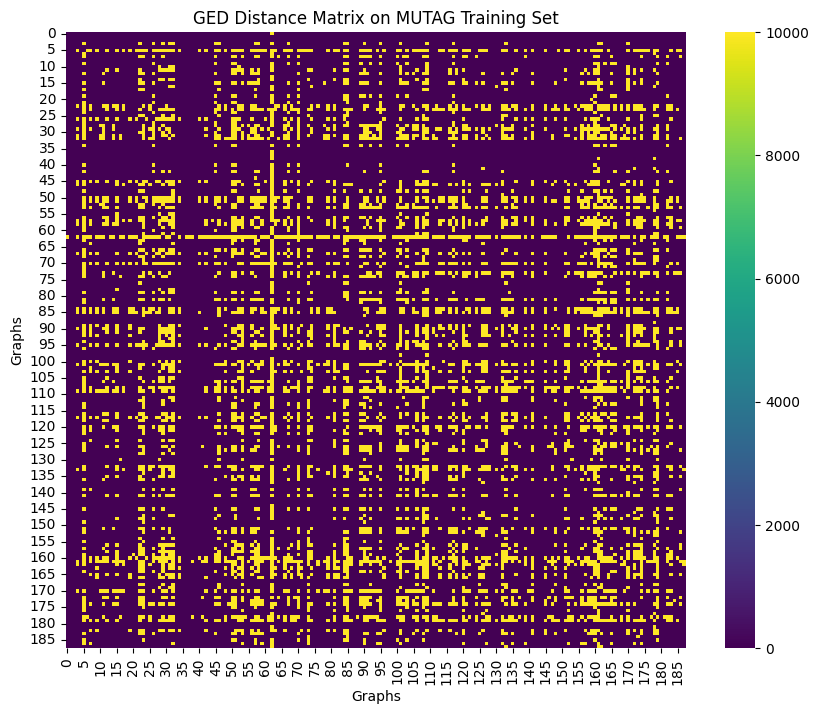

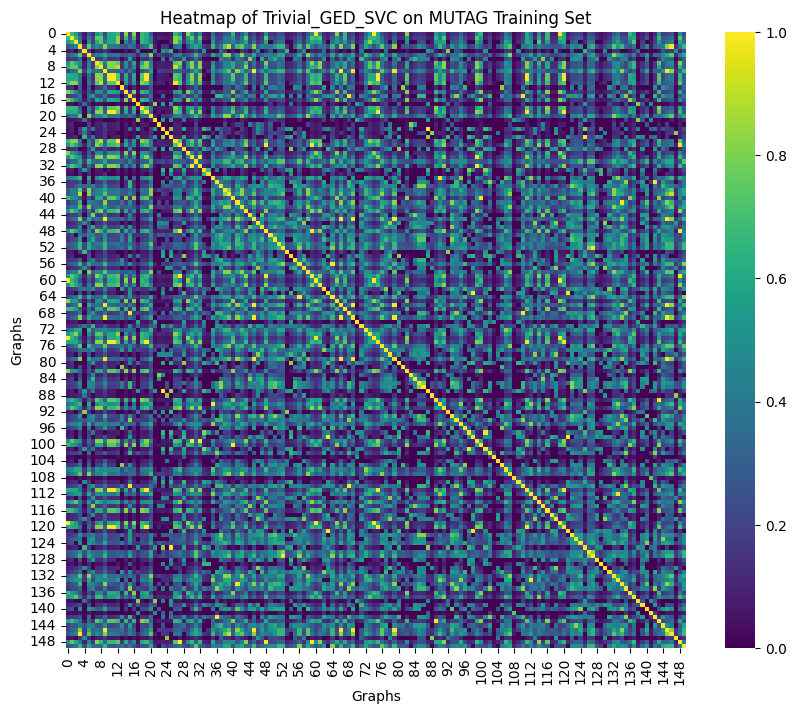

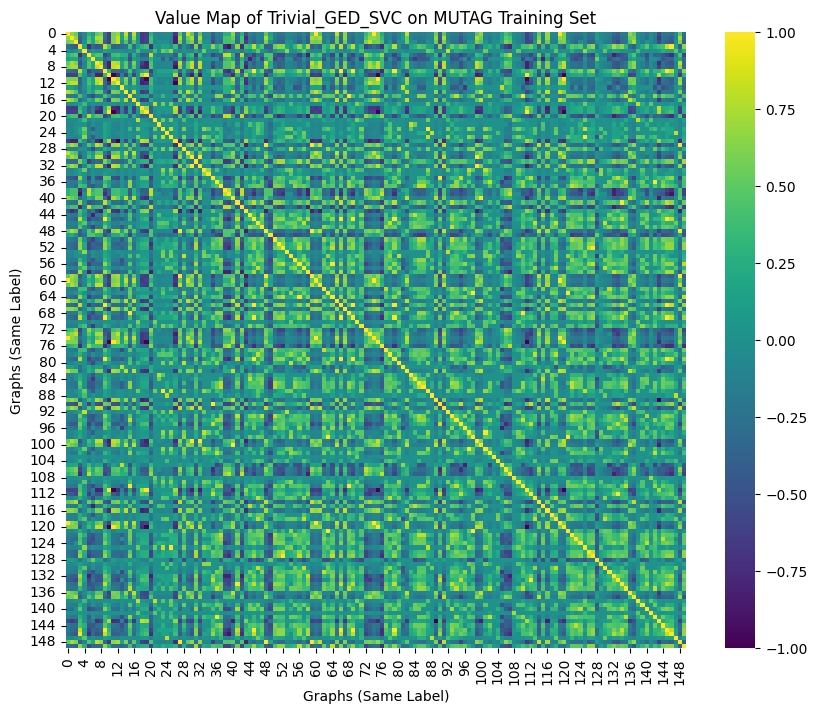

In [6]:
classifier = get_classifier(ged_calculator)
ged_matrix_train = ged_calculator.get_complete_matrix(method=GED_BOUND)
display_heatmap(ged_matrix_train, title=f"GED Distance Matrix on {DATASET.name} Training Set")
heatmap = classifier.fit_transform(X_train,y_train)
display_heatmap(heatmap, title=f"Heatmap of {classifier.__class__.__name__} on {DATASET.name} Training Set")
# display_heatmap(labels_map, title=f"Same Labels Map on {DATASET.name} Training Set", xlabel="Graphs (Same Label)", ylabel="Graphs (Same Label)")
# display_heatmap([y_train], title="labels of the training set")
value_map=heatmap * labels_map
display_heatmap(value_map, title=f"Value Map of {classifier.__class__.__name__} on {DATASET.name} Training Set", xlabel="Graphs (Same Label)", ylabel="Graphs (Same Label)")